In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, HypothesisTests
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [13]:
d, Nobs = 5, 1000
pX = 1e-1
X = sprandn(d, Nobs, pX)
X[1,:] = 1
for i in 2:d 
    nzind = X[i,:].nzind
    X[i,nzind] = rand(Laplace(),length(nzind))
end
y = zeros(Nobs)
y[1] = 1
mb_size = 10;

In [14]:
σ02 = 1e0
prior = gaussian_prior_nh(zeros(d), σ02*ones(d));

In [15]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [16]:
# Sub-sampling with weights and no CV

prob_het = 0.99
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs,mb_size)
@showprogress for i in 2:d 
    nzind = X[i,:].nzind
    weights_het = spzeros(Nobs)
    weights_het[nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list_noCV = mbsampler_list(d,gs);

In [17]:
# Sub-sampling with weights and with CV 

norm_Xj = [norm(X[:,j]) for j in 1:Nobs]
prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs,mb_size)
for i in 2:d 
    nz_ind = X[i,:].nzind
    weights_het = spzeros(Nobs)
    weights_het[nz_ind] = abs.(X[i,nz_ind]).*norm_Xj[nz_ind]
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list_CV = cvmbsampler_list(my_model, gs, root, true);

In [18]:
A = eye(d)
opf = projopf(A, 100)
opt = maxa_opt(10^6)
outp_CV = outputscheduler(deepcopy(opf),deepcopy(opt))
bb_ll_CV = build_bound(my_model.ll, gs_list_CV)
bb_pr_CV = build_bound(my_model.pr)
mstate_CV = zz_state(d)
outp_noCV = outputscheduler(deepcopy(opf),deepcopy(opt))
bb_ll_noCV = build_bound(my_model.ll, gs_list_noCV)
bb_pr_noCV = build_bound(my_model.pr)
mstate_noCV = zz_state(d)

L = 2
adapt_speed = "none"

my_zz_sampler_CV = zz_sampler_decoupled(0, gs_list_CV, bb_pr_CV, bb_ll_CV, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_CV, my_zz_sampler_CV, mstate_CV);

my_zz_sampler_noCV = zz_sampler_decoupled(0, gs_list_noCV, bb_pr_noCV, bb_ll_noCV, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_noCV, my_zz_sampler_noCV, mstate_noCV);

10% attempts in 0.28 mins 
20% attempts in 0.56 mins 
30% attempts in 0.85 mins 
40% attempts in 1.14 mins 
50% attempts in 1.43 mins 
60% attempts in 1.72 mins 
70% attempts in 2.0 mins 
80% attempts in 2.28 mins 
90% attempts in 2.57 mins 
100% attempts in 2.85 mins 
10% attempts in 0.14 mins 
20% attempts in 0.29 mins 
30% attempts in 0.43 mins 
40% attempts in 0.58 mins 
50% attempts in 0.72 mins 
60% attempts in 0.86 mins 
70% attempts in 1.01 mins 
80% attempts in 1.15 mins 
90% attempts in 1.3 mins 
100% attempts in 1.44 mins 


In [20]:
n_samples = 10^4
xi_samples_CV_ = extract_samples(outp_CV.opf.xi_skeleton, 
                                outp_CV.opf.bt_skeleton, 
                                outp_CV.opf.bt_skeleton[end]/n_samples,
                                "linear");
xi_samples_noCV_ = extract_samples(outp_noCV.opf.xi_skeleton, 
                                outp_noCV.opf.bt_skeleton, 
                                outp_noCV.opf.bt_skeleton[end]/n_samples,
                                "linear");

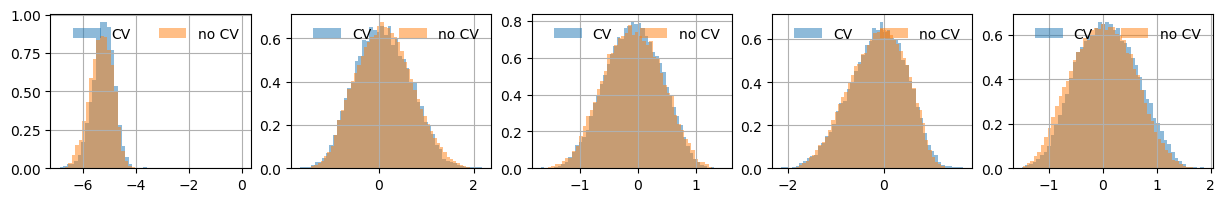

In [21]:
fig = figure(figsize=(15,2))
for i in 1:d 
    subplot(1,d,i)
    hist(xi_samples_CV_[i,:], bins=50, density=true, alpha=0.5, label="CV")
    hist(xi_samples_noCV_[i,:], bins=50, density=true, alpha=0.5, label="no CV")
    legend(ncol=2, frameon=false)
    grid(true)
end

In [8]:
n_samples = 10^4
xi_samples_CV = extract_samples(outp_CV.opf.xi_skeleton, 
                                outp_CV.opf.bt_skeleton, 
                                outp_CV.opf.bt_skeleton[end]/n_samples,
                                "linear");
xi_samples_noCV = extract_samples(outp_noCV.opf.xi_skeleton, 
                                outp_noCV.opf.bt_skeleton, 
                                outp_noCV.opf.bt_skeleton[end]/n_samples,
                                "linear");

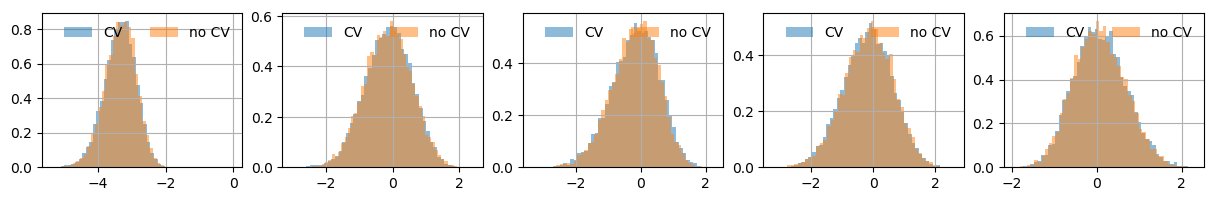

In [9]:
fig = figure(figsize=(15,2))
for i in 1:d 
    subplot(1,d,i)
    hist(xi_samples_CV[i,:], bins=50, density=true, alpha=0.5, label="CV")
    hist(xi_samples_noCV[i,:], bins=50, density=true, alpha=0.5, label="no CV")
    legend(ncol=2, frameon=false)
    grid(true)
end

In [10]:
[pvalue(ExactOneSampleKSTest(xi_samples_CV[i,:], Normal(mean(xi_samples_CV[i,:]),std(xi_samples_CV[i,:]))))
    for i in 1:d]

5-element Array{Float64,1}:
 0.000192537
 0.0529502  
 3.57382e-6 
 0.0332138  
 0.000821637

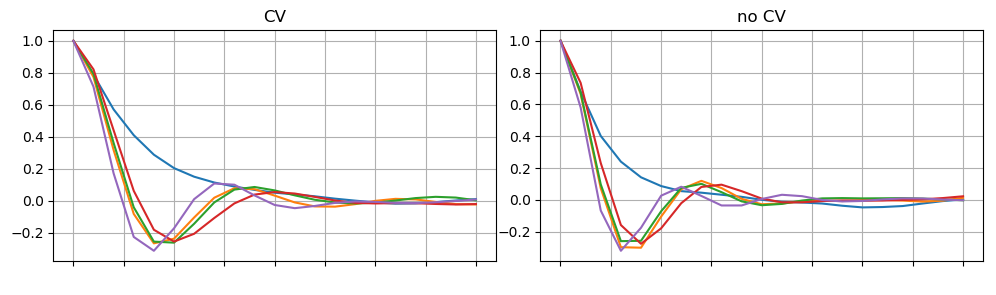

In [26]:
maxlag = 20
fig = figure(figsize=(12,3))
for i in 1:d
    subplot(121)
    plot(acf(xi_samples_CV[i,1000:end-2],maxlag))
    if i == 1 title("CV") end 
    if i<d xticks(alpha=0) end
    grid(true)
    
    subplot(122)
    plot(acf(xi_samples_noCV[i,1000:end-2],maxlag))
    if i == 1 title("no CV") end 
    if i<d xticks(alpha=0) end
    grid(true)
end
subplots_adjust(wspace=0.1, hspace=0.01)

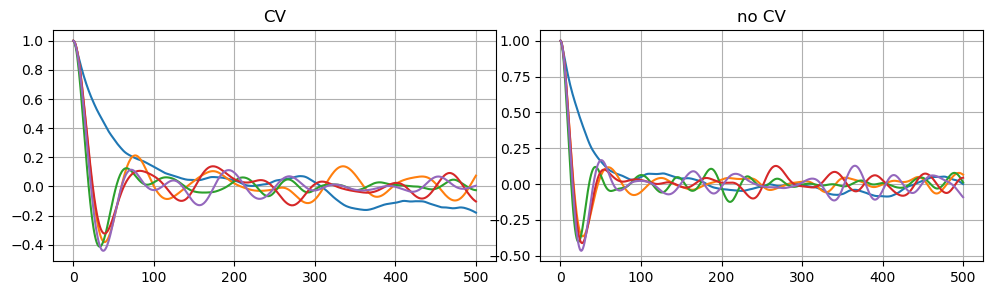

In [29]:
maxlag = 500
fig = figure(figsize=(12,3))
for i in 1:d
    subplot(121)
    plot(acf(xi_samples_CV_[i,1000:end-2],maxlag))
    title("CV")
    grid(true)
    
    subplot(122)
    plot(acf(xi_samples_noCV_[i,1000:end-2],maxlag))
    title("no CV")
    grid(true)
end
subplots_adjust(wspace=0.1, hspace=0.01)

### Tracelots:

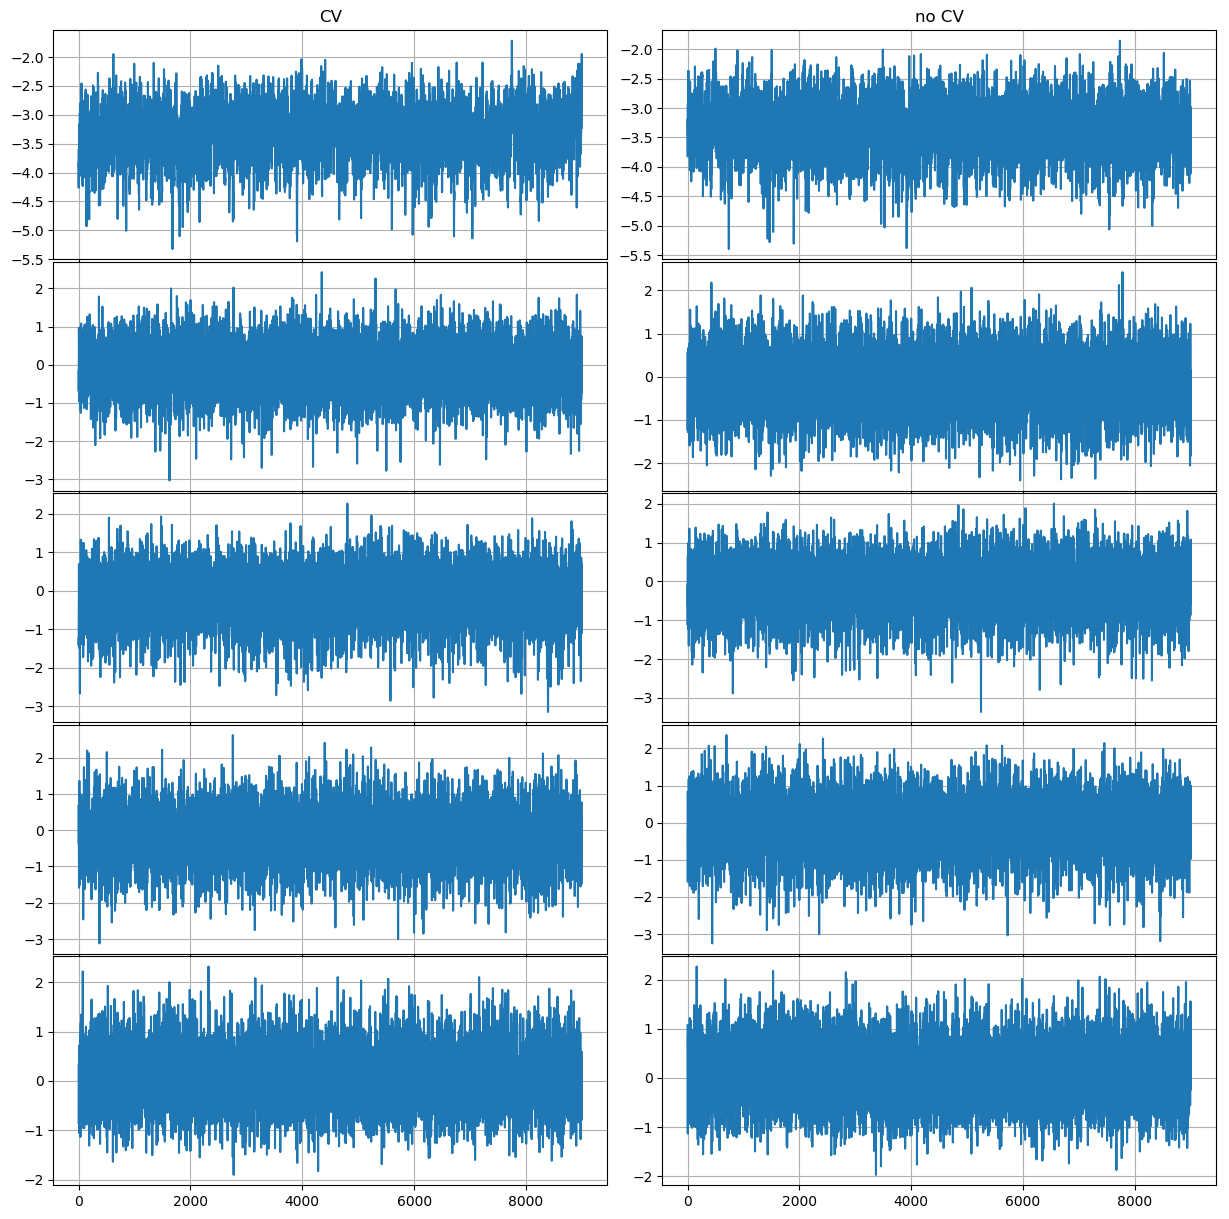

In [12]:
fig = figure(figsize=(15,15))
for i in 1:d
    subplot(d,2,2*(i-1)+1)
    plot(xi_samples_CV[i,1000:end-2])
    if i == 1 title("CV") end 
    if i<d xticks(alpha=0) end
    grid(true)
    
    subplot(d,2,3*(i-1)+2)
    plot(xi_samples_noCV[i,1000:end-2])
    if i == 1 title("no CV") end 
    grid(true)
    if i<d xticks(alpha=0) end
end
subplots_adjust(wspace=0.1, hspace=0.01)